In [1]:
from __future__ import division, print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"
IMAGE_DIR = os.path.join(DATA_DIR, "holiday-photos")

Grouping rule:

    100301.jpg -> (1003)(01).jpg

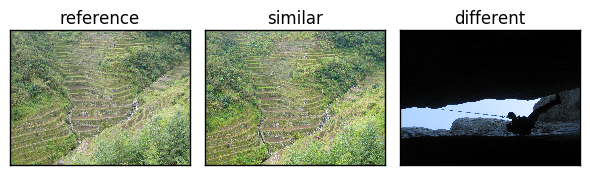

In [3]:
ref_image = plt.imread(os.path.join(IMAGE_DIR, "100301.jpg"))
sim_image = plt.imread(os.path.join(IMAGE_DIR, "100302.jpg"))
dif_image = plt.imread(os.path.join(IMAGE_DIR, "127202.jpg"))

def draw_image(subplot, image, title):
    plt.subplot(subplot)
    plt.imshow(image)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
draw_image(131, ref_image, "reference")
draw_image(132, sim_image, "similar")
draw_image(133, dif_image, "different")
plt.tight_layout()
plt.show()

There are 1491 images in this dataset.

I want to train a network to predict (reference, similar) images pairs are similar and (reference, different) image pairs are different. My dataset has only about 2072 similar image pairs of this kind. Adding one different image pair for each similar pair is done by selecting an image from the dataset randomly and pairing it with the LHS of the similar image pair. So now we have a dataset of 2072 similar and 2072 different images, for a total of 4144 image pairs.

In [4]:
image_groups = {}
for image_name in os.listdir(IMAGE_DIR):
    base_name = image_name[0:-4]
    group_name = base_name[0:4]
    if image_groups.has_key(group_name):
        image_groups[group_name].append(image_name)
    else:
        image_groups[group_name] = [image_name]

num_sim = 0
image_triples = []
group_list = sorted(list(image_groups.keys()))
for i, g in enumerate(group_list):
    if num_sim % 100 == 0:
        print("Generated {:d} pos + {:d} neg = {:d} total image triples"
              .format(num_sim, num_sim, 2*num_sim), end="\r")
    images_in_group = image_groups[g]
    # generate similar pairs
    sim_pairs_it = itertools.combinations(images_in_group, 2)
    # for each similar pair, generate a different pair
    for ref_image, sim_image in sim_pairs_it:
        image_triples.append((ref_image, sim_image, 1))
        num_sim += 1
        while True:
            j = np.random.randint(low=0, high=len(group_list), size=1)[0]
            if j != i: break
        dif_image_candidates = image_groups[group_list[j]]
        k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
        dif_image = dif_image_candidates[k]
        image_triples.append((ref_image, dif_image, 0))
        
print("Generated {:d} pos + {:d} neg = {:d} total image triples, COMPLETE"
      .format(num_sim, num_sim, 2*num_sim))

Generated 2072 pos + 2072 neg = 4144 total image triples, COMPLETE


In [5]:
def image_triple_generator(image_triples, batch_size):
    while True:
        # loop once per epoch
        num_recs = len(image_triples)
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            yield [image_triples[i] for i in batch_indices]
            
triples_batch_gen = image_triple_generator(image_triples, 4)
triples_batch_gen.next()

[('136006.jpg', '136009.jpg', 1),
 ('143803.jpg', '143801.jpg', 1),
 ('149602.jpg', '149600.jpg', 1),
 ('115702.jpg', '115701.jpg', 1)]

In [6]:
triples_batch_gen.next()

[('104001.jpg', '124500.jpg', 0),
 ('104902.jpg', '104900.jpg', 1),
 ('119603.jpg', '105201.jpg', 0),
 ('115601.jpg', '135302.jpg', 0)]

I would like to generate more examples for training using the [Keras ImageDataGenerator](https://keras.io/preprocessing/image/) where I apply the same transformation to both the images in the pair.

The documentation page above contains information about applying it to pairs of images such as input and mask (output) images, which could be applied to (reference, similar) and (reference, different) pairs for our use case. It involves building two ImageDataGenerators with identical parameters, and zipping them together and passing the zipped ImageGenerator pair into the model's fit_generator function.

My use case is slightly different. I only have triplets with the image names and label as shown above. I would prefer not to have to physically separate out the LHS and RHS images into their separate directories (and actually I am not sure if that would even work, since I suspect I would have to rename them somehow). A simpler method seems to be to call the ImageDataGenerator from within my image_triple_generator function and apply a random transform on the fly to each image.

There is a "private" (in the sense of not documented) method called random_transform in ImageDataGenerator that takes an 3-D image tensor which I am hoping to exploit for this.

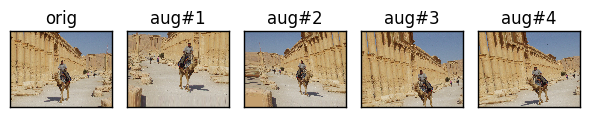

In [7]:
datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)
datagen = ImageDataGenerator(**datagen_args)

sid = 150
np.random.seed(42)
image = plt.imread(os.path.join(IMAGE_DIR, "115201.jpg"))
sid += 1
draw_image(sid, image, "orig")
for j in range(4):
    augmented = datagen.random_transform(image)
    sid += 1
    draw_image(sid, augmented, "aug#{:d}".format(j + 1))

plt.tight_layout()
plt.show()

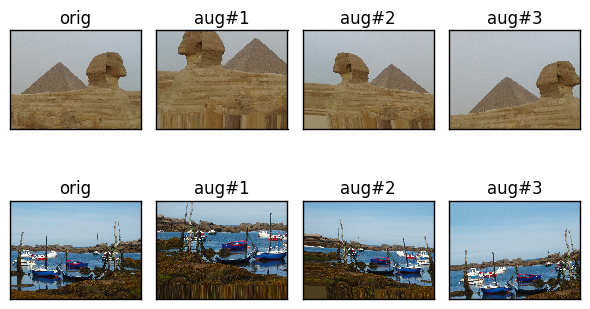

In [8]:
image_pair = ["108103.jpg", "112003.jpg"]

datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]

sid = 240
for i, image in enumerate(image_pair):
    image = plt.imread(os.path.join(IMAGE_DIR, image_pair[i]))
    sid += 1
    draw_image(sid, image, "orig")
    # make sure the two image data generators generate same transformations
    np.random.seed(42)
    for j in range(3):
        augmented = datagens[i].random_transform(image)
        sid += 1
        draw_image(sid, augmented, "aug#{:d}".format(j + 1))

plt.tight_layout()
plt.show()

In [9]:
RESIZE_WIDTH = 300
RESIZE_HEIGHT = 300

def cached_imread(image_path, image_cache):
    if not image_cache.has_key(image_path):
        image = plt.imread(image_path)
        image = imresize(image, (RESIZE_WIDTH, RESIZE_HEIGHT))
        image_cache[image_path] = image
    return image_cache[image_path]

def preprocess_images(image_names, seed, datagen, image_cache):
    np.random.seed(seed)
    X = np.zeros((len(image_names), RESIZE_WIDTH, RESIZE_HEIGHT, 3))
    for i, image_name in enumerate(image_names):
        image = cached_imread(os.path.join(IMAGE_DIR, image_name), image_cache)
        X[i] = datagen.random_transform(image)
    return X

def image_triple_generator(image_triples, batch_size):
    datagen_args = dict(rotation_range=10,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
    datagen_left = ImageDataGenerator(**datagen_args)
    datagen_right = ImageDataGenerator(**datagen_args)
    image_cache = {}
    
    while True:
        # loop once per epoch
        num_recs = len(image_triples)
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [image_triples[i] for i in batch_indices]
            # make sure the two image data generators generate same transformations
            seed = np.random.randint(low=0, high=1000, size=1)[0]
            Xleft = preprocess_images([b[0] for b in batch], seed, datagen_left, image_cache)
            Xright = preprocess_images([b[1] for b in batch], seed, datagen_right, image_cache)
            Y = np_utils.to_categorical(np.array([b[2] for b in batch]))
            yield Xleft, Xright, Y

In [10]:
triples_batch_gen = image_triple_generator(image_triples, 32)
Xleft, Xright, Y = triples_batch_gen.next()
print(Xleft.shape, Xright.shape, Y.shape)

(32, 300, 300, 3) (32, 300, 300, 3) (32, 2)
